<a href="https://colab.research.google.com/github/gracekazmierski/machinelearning/blob/main/gehirnwagen_road_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import necessary libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from glob import glob
import shutil
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

In [4]:
from collections import defaultdict

training_dir = '/content/training'
speed_sign_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
duplication_factor = 1.5  # 50% increase
counts_before = defaultdict(int)
counts_after = defaultdict(int)

for class_idx in speed_sign_indices:
    class_folder = f"{class_idx:05d}"  # Converts 0 → '00000', etc.
    class_path = os.path.join(training_dir, class_folder)
    images = glob(os.path.join(class_path, '*'))

    num_to_duplicate = int(len(images) * (duplication_factor - 1))
    print(f"Oversampling class {class_idx} ({target_names[class_idx]}): +{num_to_duplicate} images")

    for i in range(num_to_duplicate):
        src = images[i % len(images)]
        base = os.path.basename(src)
        dst = os.path.join(class_path, f"dup_{i}_{base}")
        shutil.copyfile(src, dst)

Oversampling class 0 (Speed_20): +105 images
Oversampling class 1 (Speed_30): +1110 images
Oversampling class 2 (Speed_50): +1125 images
Oversampling class 3 (Speed_60): +705 images
Oversampling class 4 (Speed_70): +990 images
Oversampling class 5 (Speed_80): +930 images
Oversampling class 6 (Speed_Limit_Ends): +210 images
Oversampling class 7 (Speed_100): +720 images
Oversampling class 8 (Speed_120): +705 images


In [5]:
# Directory with training images
training_dir = '/content/training/'

# Resize images to this size
image_size = (100, 100)

# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixel values
    rotation_range=15,              # Random rotation
    width_shift_range=0.1,          # Horizontal shift
    height_shift_range=0.1,         # Vertical shift
    shear_range=0.1,                # Shear transformation
    zoom_range=0.1,                 # Random zoom
    brightness_range=[0.8, 1.2],    # Vary brightness
    fill_mode='nearest',            # Fill in missing pixels
    validation_split=0.2,            # Reserve 20% for validation
    horizontal_flip=False
)

# Validation data generator (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values
    validation_split=0.2            # Same split as training
)

In [6]:
# Load training images with augmentation
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,     # Resize all images
    subset="training",          # Use training split
    batch_size=32,              # Number of images per batch
    class_mode='sparse',        # Labels are integers, not one-hot
    seed=42,                    # Ensure same split every run
    shuffle=True                # Shuffle training data
)

# Map label indices back to class names
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Load validation images (no augmentation)
validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",        # Use validation split
    seed=42,
    shuffle=False
)

# Get total number of classes
num_classes = len(train_generator.class_indices)


Found 36648 images belonging to 43 classes.
Found 9161 images belonging to 43 classes.


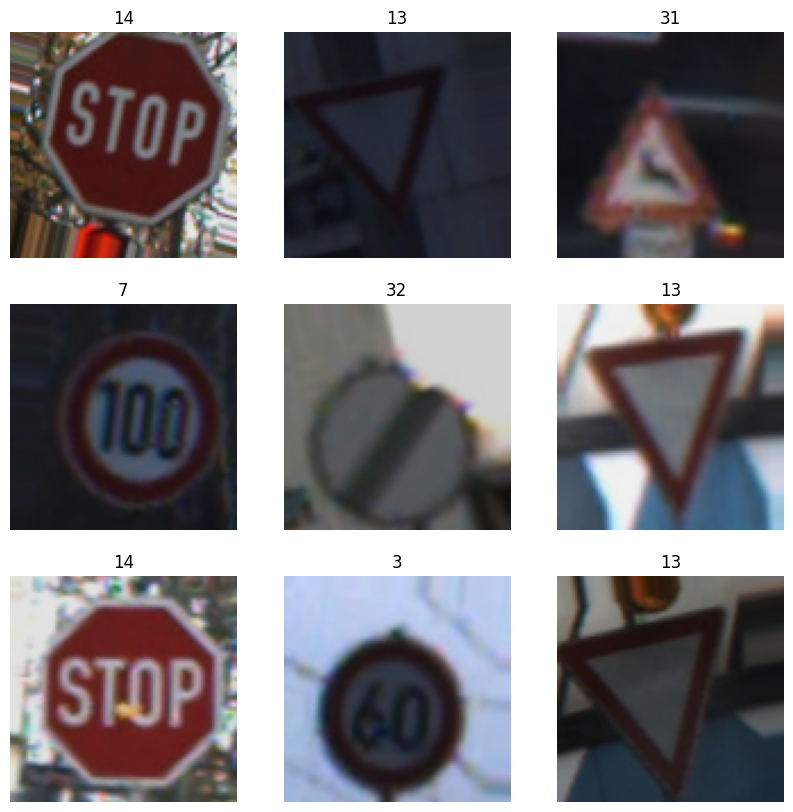

In [7]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [8]:
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),  # Conv layer with 32 filters
    BatchNormalization(),                                             # Normalize activations
    MaxPooling2D((2, 2)),                                             # Downsample feature map

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),                            # More filters for deeper features
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),                           # Even more filters
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps for dense layers
    Flatten(),

    # Fully Connected Layers
    Dense(512, activation='relu'),                                    # Large dense layer
    BatchNormalization(),
    Dropout(0.5),                                                     # Prevent overfitting
    Dense(num_classes, activation='softmax')                          # Output layer for classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model with optimizer, loss, and metric
model.compile(
    optimizer='adam',                          # Adaptive optimizer
    loss='sparse_categorical_crossentropy',    # For integer labels
    metrics=['accuracy']                       # Track accuracy during training
)

# Show model architecture and parameter counts
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,672,363 (25.45 MB)

 Trainable params: 6,670,891 (25.45 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [10]:
# Stop training if val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate if val_loss plateaus for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,                              # Max epochs
    validation_data=validation_generator,  # Use validation split
    callbacks=[early_stopping, reduce_lr, checkpoint],  # Stop early or lower LR if needed
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4720 - loss: 2.0527
Epoch 1: val_accuracy improved from -inf to 0.88440, saving model to best_model.keras
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 167s 138ms/step - accuracy: 0.4721 - loss: 2.0519 - val_accuracy: 0.8844 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 2/25
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9152 - loss: 0.2719
Epoch 2: val_accuracy improved from 0.88440 to 0.91606, saving model to best_model.keras
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 190s 132ms/step - accuracy: 0.9152 - loss: 0.2719 - val_accuracy: 0.9161 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 3/25
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9575 - loss: 0.1373
Epoch 3: val_accuracy improved from 0.91606 to 0.94389, saving model to best_model.keras
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 150s 131ms/step - accuracy: 0.9575 - loss: 0.1373 - val_accuracy: 0.9439 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 4/25
1146/1146 ━━━━

In [11]:
history_dict = history.history
acc = history_dict['accuracy']          # Training accuracy
val_acc = history_dict['val_accuracy']  # Validation accuracy
loss = history_dict['loss']            # Training loss
val_loss = history_dict['val_loss']    # Validation loss

# Get number of completed epochs (can be < max due to early stopping)
epochs_range = range(len(acc))

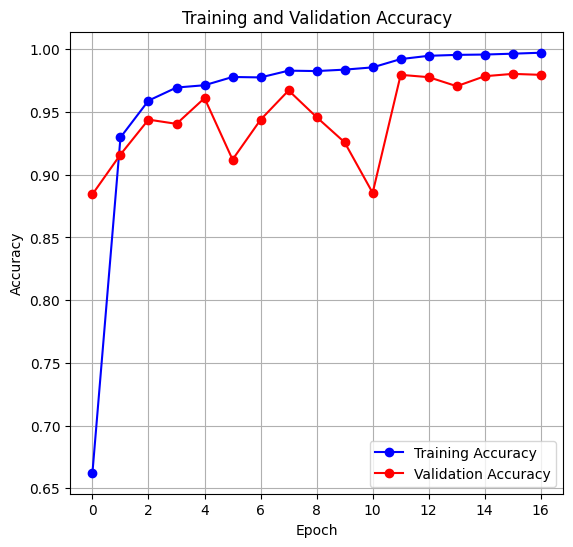

In [12]:
plt.figure(figsize=(14, 6))

# Plot 1: Accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

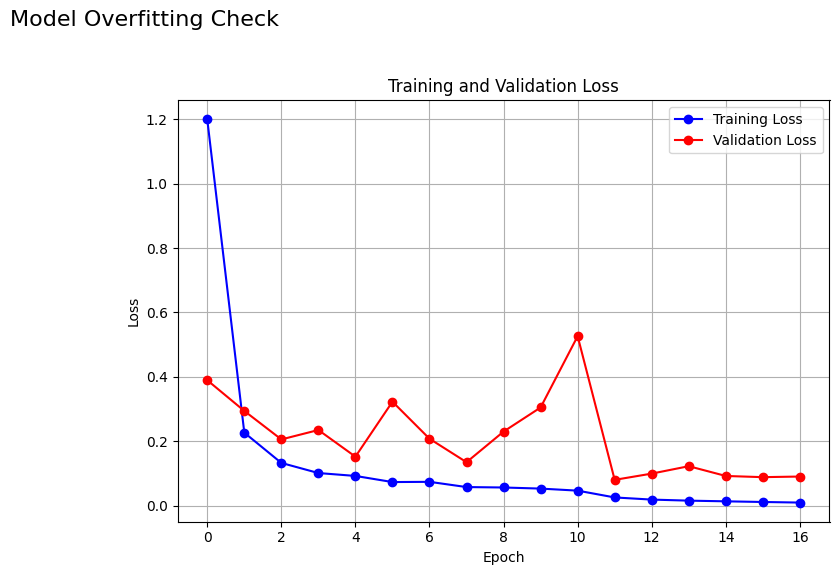

In [13]:
plt.figure(figsize=(14, 6))

# Plot 2: Loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Add a main title and adjust spacing
plt.suptitle('Model Overfitting Check', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [63]:
# loaded_model = load_model('best_model.keras')
# print("Model loaded successfully.")

# # Show structure of the loaded model
# print("\nSummary of the loaded model:")
# loaded_model.summary()
# model = loaded_model

In [61]:
answers_df = pd.read_csv('/content/mini_holdout_answers.csv')
true_labels = answers_df['ClassId'].values

In [40]:
# Directory with unlabeled test images
test_dir = '/content/'

# Only rescale pixels; no augmentation
mini_holdout_datagen = ImageDataGenerator(rescale=1./255)

# Load test images from 'mini_holdout' folder
mini_holdout_generator = mini_holdout_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],      # Look only in this subfolder
    target_size=image_size,        # Resize to match training images
    class_mode=None,               # No labels since we're predicting
    shuffle=False                  # Keep order for correct mapping
)

# Make predictions on test data
probabilities = model.predict(mini_holdout_generator)

# Convert softmax probabilities to predicted class indices
mini_predictions = [np.argmax(probas) for probas in probabilities]

Found 201 images belonging to 1 classes.
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [41]:
f1_per_class = f1_score(true_labels, mini_predictions, average=None)

perfect_classes = [i for i, f1 in enumerate(f1_per_class) if f1 == 1.0]
print(f"✅ F1 score of 1.00 on classes: {perfect_classes}")

✅ F1 score of 1.00 on classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [42]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(true_labels, mini_predictions)
print(f"Overall accuracy: {overall_acc:.2%}")

if overall_acc < 0.95:
    print("❌ Accuracy below 95%.")

Overall accuracy: 99.50%


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure arrays
y_true = np.array(true_labels)
y_pred = np.array(mini_predictions)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# R^2 Score
r2 = r2_score(y_true, y_pred)

print(f"\nRMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

stop_sign_index = 14  # STOP is at index 14

# Mask for STOP signs
stop_mask = (true_labels == stop_sign_index)

# True and predicted labels for STOP signs
stop_true = true_labels[stop_mask]
stop_preds = np.array(mini_predictions)[stop_mask]

stop_acc = accuracy_score(stop_true, stop_preds)
print(f"Accuracy on STOP signs only: {stop_acc:.2%}")

stop_f1 = f1_score(stop_true, stop_preds, average='macro')
print(f"F1 Score on STOP signs only: {stop_f1:.2f}")

print(f"Overall accuracy: {overall_acc:.2%}")


RMSE: 0.4937
MAE: 0.0348
R² Score: 0.9981
Accuracy on STOP signs only: 100.00%
F1 Score on STOP signs only: 1.00
Overall accuracy: 99.50%


In [44]:
warning_info_indices = [
    18,  # General Danger(!)
    19,  # Left_Curve_Ahead
    20,  # Right_Curve_Ahead
    21,  # Double_Curve
    22,  # Poor_Surface_Ahead
    23,  # Slippery_Surface_Ahead
    24,  # Road_Narrows_On_Right
    25,  # Roadwork_Ahead
    26,  # Traffic_Light_Ahead
    27,  # Warning_Pedestrians
    28,  # Warning_Children
    29,  # Warning_Bikes
    30,  # Ice_Snow
    31   # Deer_Crossing
]

In [45]:
import numpy as np

# Convert predictions to array
predictions = np.array(mini_predictions)

# Example: Check each class
for i, name in enumerate(target_names):
    class_mask = (true_labels == i)
    class_true = true_labels[class_mask]
    class_pred = predictions[class_mask]

    class_acc = accuracy_score(class_true, class_pred)

    # Categorize
    if i in warning_info_indices:
        required = 0.85
    else:
        required = 0.98

    status = "✅" if class_acc >= required else "❌"
    print(f"{status} {name}: {class_acc:.2%}")

❌ Speed_20: nan%
✅ Speed_30: 100.00%
✅ Speed_50: 100.00%
✅ Speed_60: 100.00%
✅ Speed_70: 100.00%
✅ Speed_80: 100.00%
✅ Speed_Limit_Ends: 100.00%
✅ Speed_100: 100.00%
✅ Speed_120: 100.00%
✅ Overtaking_Prohibited: 100.00%
✅ Overtakeing_Prohibited_Trucks: 100.00%
✅ Priority: 100.00%
✅ Priority_Road_Ahead: 100.00%
✅ Yield: 100.00%
✅ STOP: 100.00%
✅ Entry_Forbidden: 100.00%
✅ Trucks_Forbidden: 100.00%
✅ No_Entry(one-way traffic): 100.00%
✅ General Danger(!): 100.00%
❌ Left_Curve_Ahead: nan%
✅ Right_Curve_Ahead: 100.00%
✅ Double_Curve: 100.00%
✅ Poor_Surface_Ahead: 100.00%
✅ Slippery_Surface_Ahead: 100.00%
✅ Road_Narrows_On_Right: 100.00%
✅ Roadwork_Ahead: 100.00%
✅ Traffic_Light_Ahead: 100.00%
✅ Warning_Pedestrians: 100.00%
✅ Warning_Children: 100.00%
✅ Warning_Bikes: 100.00%
❌ Ice_Snow: 75.00%
✅ Deer_Crossing: 100.00%
✅ End_Previous_Limitation: 100.00%
✅ Turning_Right_Compulsory: 100.00%
✅ Turning_Left_Compulsory: 100.00%
✅ Ahead_Only: 100.00%
✅ Straight_Or_Right_Mandatory: 100.00%
❌ Strai

In [51]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Ensure numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(mini_predictions)

# Full confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Totals
TP = np.trace(cm)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TN = cm.sum() - (FP + FN + np.diag(cm))

# Sum up for binary-style view
total_FP = FP.sum()
total_FN = FN.sum()
total_TN = TN.sum()

print("\n--- Confusion Matrix (Summed View) ---")
print(f"TP | TN\n{TP} | {total_TN}")
print(f"FP | FN\n{total_FP} | {total_FN}")



--- Confusion Matrix (Summed View) ---
TP | TN
200 | 7436
FP | FN
1 | 1


In [47]:
# Recreate the generator just to get class indices
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (100, 100)
test_dir = '/content/training'

temp_datagen = ImageDataGenerator(rescale=1./255)
temp_generator = temp_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    class_mode='sparse'
)

# Recover idx_to_class and class_names
idx_to_class = {v: k for k, v in temp_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

Found 45809 images belonging to 43 classes.


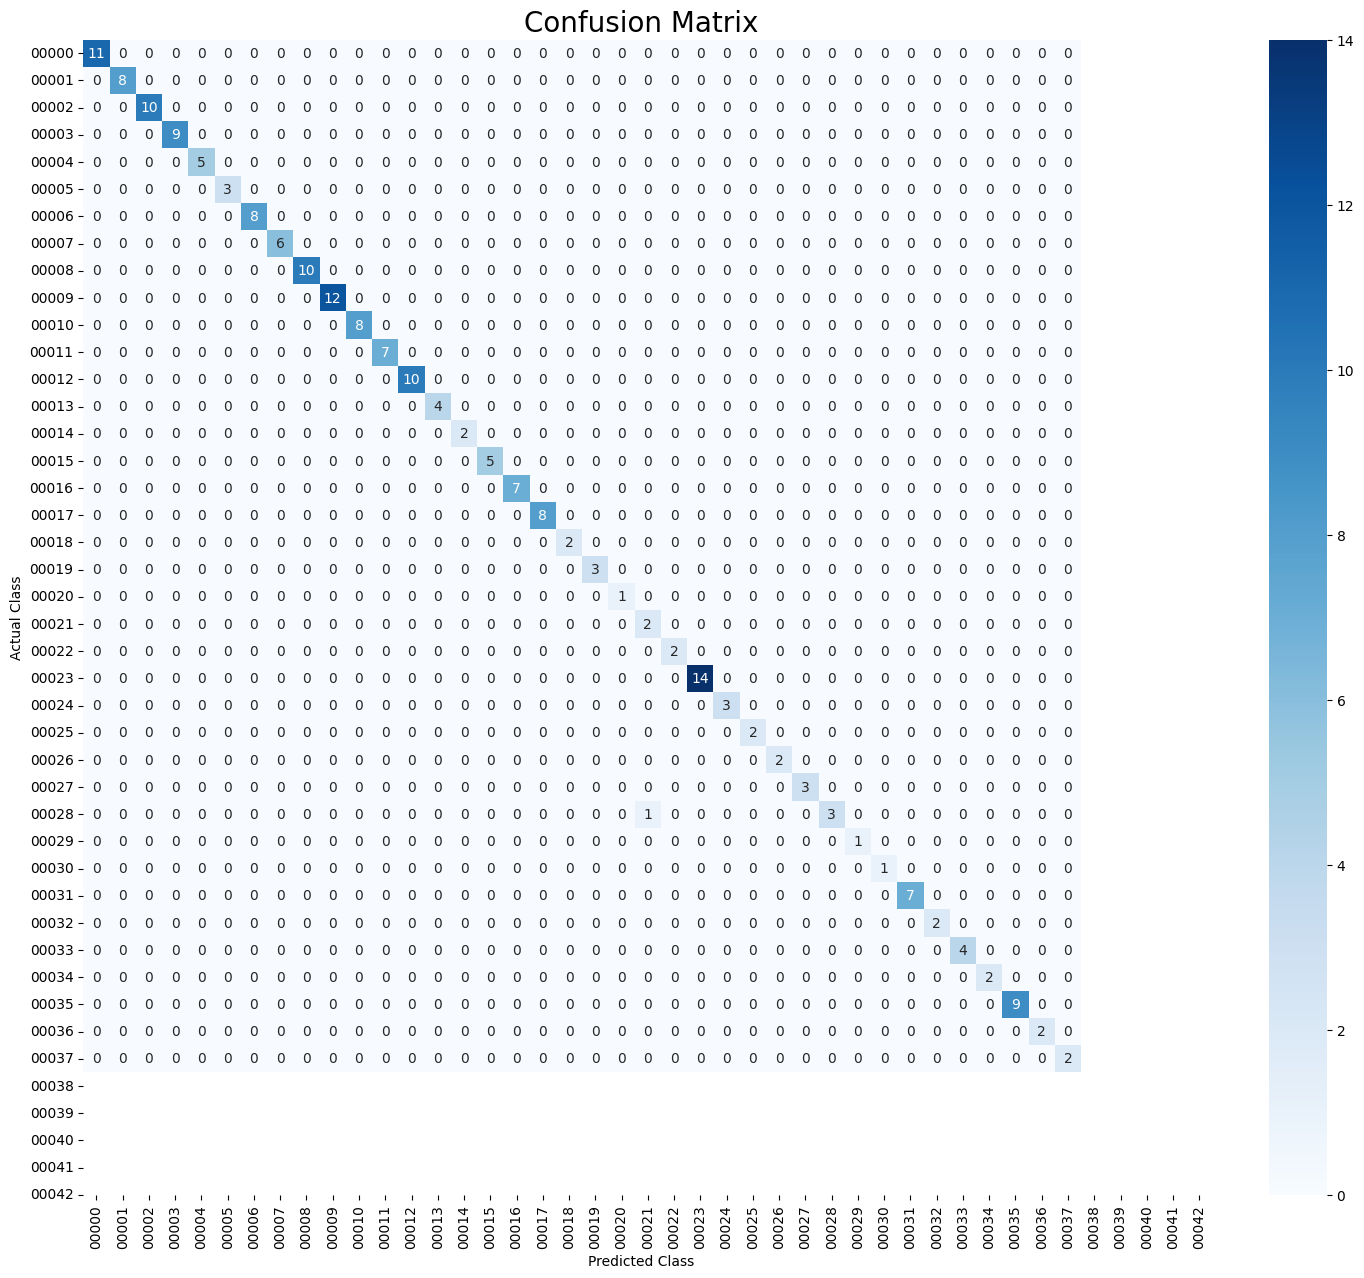

In [48]:
cm = confusion_matrix(true_labels, mini_predictions)

plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [49]:
from sklearn.metrics import multilabel_confusion_matrix

# Compute TP, FP, FN, TN for each class
mcm = multilabel_confusion_matrix(true_labels, mini_predictions, labels=range(len(target_names)))

print(f"{'Class':35s} | TP   FP   FN   TN")
print("-" * 60)

for i, (tn, fp, fn, tp) in enumerate(mcm.reshape(len(target_names), 4)):
    print(f"{target_names[i]:35s} | {tp:2d}   {fp:2d}   {fn:2d}   {tn:2d}")

Class                               | TP   FP   FN   TN
------------------------------------------------------------
Speed_20                            |  0    0    0   201
Speed_30                            | 11    0    0   190
Speed_50                            |  8    0    0   193
Speed_60                            | 10    0    0   191
Speed_70                            |  9    0    0   192
Speed_80                            |  5    0    0   196
Speed_Limit_Ends                    |  3    0    0   198
Speed_100                           |  8    0    0   193
Speed_120                           |  6    0    0   195
Overtaking_Prohibited               | 10    0    0   191
Overtakeing_Prohibited_Trucks       | 12    0    0   189
Priority                            |  8    0    0   193
Priority_Road_Ahead                 |  7    0    0   194
Yield                               | 10    0    0   191
STOP                                |  4    0    0   197
Entry_Forbidden             

In [53]:
from sklearn.utils.multiclass import unique_labels

labels_used = sorted(unique_labels(true_labels, mini_predictions))
class_names_subset = [idx_to_class[i] for i in labels_used]

print("\n--- Classification Report ---")
print(classification_report(true_labels, mini_predictions, labels=labels_used, target_names=class_names_subset))


--- Classification Report ---
              precision    recall  f1-score   support

       00001       1.00      1.00      1.00        11
       00002       1.00      1.00      1.00         8
       00003       1.00      1.00      1.00        10
       00004       1.00      1.00      1.00         9
       00005       1.00      1.00      1.00         5
       00006       1.00      1.00      1.00         3
       00007       1.00      1.00      1.00         8
       00008       1.00      1.00      1.00         6
       00009       1.00      1.00      1.00        10
       00010       1.00      1.00      1.00        12
       00011       1.00      1.00      1.00         8
       00012       1.00      1.00      1.00         7
       00013       1.00      1.00      1.00        10
       00014       1.00      1.00      1.00         4
       00015       1.00      1.00      1.00         2
       00016       1.00      1.00      1.00         5
       00017       1.00      1.00      1.00       

In [54]:
# Create a DataFrame with predicted class IDs
predictions_df = pd.DataFrame({'ClassId': mini_predictions})

# Save predictions to CSV file
file_path = 'mini_holdout_predictions.csv'
predictions_df.to_csv(file_path, index=False)

print(f"\nPredictions successfully saved to {file_path}")
print(f"The file has {len(mini_predictions)} predictions.")

print("\nFirst 5 predictions:")
print(predictions_df.head())


Predictions successfully saved to mini_holdout_predictions.csv
The file has 201 predictions.

First 5 predictions:
   ClassId
0       16
1        1
2       38
3       33
4       11


In [55]:
test_dir = '/content/'            # Base directory containing 'holdout/' folder
image_size = (100, 100)           # Must match model input shape

# Normalize pixel values (0–1 range)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from 'holdout' folder (no labels, no shuffle)
holdout_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['holdout'],          # Only load images from this subfolder
    target_size=image_size,       # Resize to match model input
    batch_size=32,                # Predict in batches
    class_mode=None,              # No labels — prediction only
    shuffle=False                 # Keep order for matching filenames
)

print("--- Generating predictions on the full holdout set ---")

# Run model prediction on holdout set
probabilities = model.predict(holdout_generator, batch_size=32)

# Convert softmax output to class index (e.g., [0.1, 0.8, 0.1] → 1)
predictions = [np.argmax(probas) for probas in probabilities]

print(f"Generated {len(predictions)} predictions.")

# Get filenames like: 'holdout/00000.png'
ordered_filenames = holdout_generator.filenames

# Extract numeric IDs (strip folder and extension)
image_ids = [os.path.basename(fn).split('.')[0] for fn in ordered_filenames]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'Id': image_ids,
    'ClassId': predictions
})

# Preview first few rows
print(submission_df.head())

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nFinal submission file successfully saved to: {submission_path}")

Found 12630 images belonging to 1 classes.
--- Generating predictions on the full holdout set ---
  4/395 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
✅ Generated 12630 predictions.
      Id  ClassId
0  00000       16
1  00001        1
2  00002       38
3  00003       33
4  00004       11

✅ Final submission file successfully saved to: submission.csv


In [57]:
training_files = set()
for dirpath, _, filenames in os.walk('/content/training'):
    for f in filenames:
        training_files.add(f)

holdout_files = set()
for dirpath, _, filenames in os.walk('/content/holdout'):
    for f in filenames:
        holdout_files.add(f)

# Find any overlapping filenames (possible data leakage)
leaked_files = training_files.intersection(holdout_files)

if not leaked_files:
    print("No filename overlap found between training and holdout sets.")
else:
    print(f"{len(leaked_files)} files in both sets.")
    print("Leaked files:", leaked_files)

No filename overlap found between training and holdout sets.


## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```